In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

### Load dataframe

In [3]:
df = pd.read_csv("/content/drive/MyDrive/UNI-STUFF/SC1015/airbnb.csv")

### Clean Data by removing NLP content.

In [4]:
df.drop(columns=['thumbnail_url','amenities', 'description',
                 'host_has_profile_pic', 'host_identity_verified',
                 'host_response_rate', 'host_since', 'name', 'neighbourhood'], inplace=True)
df.columns

Index(['id', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'first_review', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'number_of_reviews', 'review_scores_rating', 'zipcode',
       'bedrooms', 'beds', 'price'],
      dtype='object')

### Clean Data by merging smaller classes

In [5]:
# Condense room_type
df['room_type'] = df['room_type'].replace({'Entire home/apt': "Private", 'Private room': "Shared", 'Shared room': "Shared"})
# Condense property_type
property_typ_vc = df["property_type"].value_counts()/50
others = property_typ_vc[property_typ_vc < 5].index
df['property_type'] = df['property_type'].replace(others, 'Other')

### Clean DateTime Data

In [6]:
df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce') # Ensure the review columns are in datetime format
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce') # Ensure the review columns are in datetime format
df['review_duration'] = (df['last_review'] - df['first_review']).dt.days # Calculate the duration between first_review and last_review in days
# We will not use 'first_review' and 'last_review' due to negligible correlation with rpice and any other features.

## EDA Stage 1: One-Hot encoding and Direct Correlation

In [7]:
clean_df = pd.DataFrame()
clean_df["price"] = df["price"] # Bring over the Y-variable. NUM
clean_df['property_type'] = df['property_type'] # Bring over property_type feature. CAT
clean_df['room_type'] = df['room_type'] # Bring over room_type feature. CAT
clean_df['accommodates'] = df['accommodates'] # Bring over accommodates feature. NUM
clean_df['bathrooms'] = df['bathrooms'] # Bring over bathrooms feature. NUM
clean_df['bed_type'] = df['bed_type'] # Bring over bed_type feature. CAT
clean_df['cancellation_policy'] = df['cancellation_policy'] # Bring over cancellation_policy feature. CAT
clean_df['cleaning_fee'] = df['cleaning_fee'] # Bring over cleaning_fee feature. BOOL
clean_df['city'] = df['city'] # Bring over city feature. CAT
clean_df['instant_bookable'] = df['instant_bookable'].map({'t': True, 'f': False}) # Bring over instant_bookable feature. BOOL
clean_df['latitude'] = df['latitude'] # Bring over latitude feature. NUM
clean_df['longitude'] = df['longitude'] # Bring over longitude feature. NUM
clean_df['number_of_reviews'] = df['number_of_reviews'] # Bring over number_of_reviews feature. NUM
clean_df['review_scores_rating'] = df['review_scores_rating'] # Bring over review_scores_rating feature. NUM
clean_df['total_review_score'] = clean_df['number_of_reviews'] * clean_df['review_scores_rating']
clean_df['zipcode'] = df['zipcode'] # Bring over zipcode feature. NUM
clean_df['bedrooms'] = df['bedrooms'] # Bring over zipcode feature. NUM
clean_df['beds'] = df['beds'] # Bring over zipcode feature. NUM

### Render Correlation Heatmap for each city

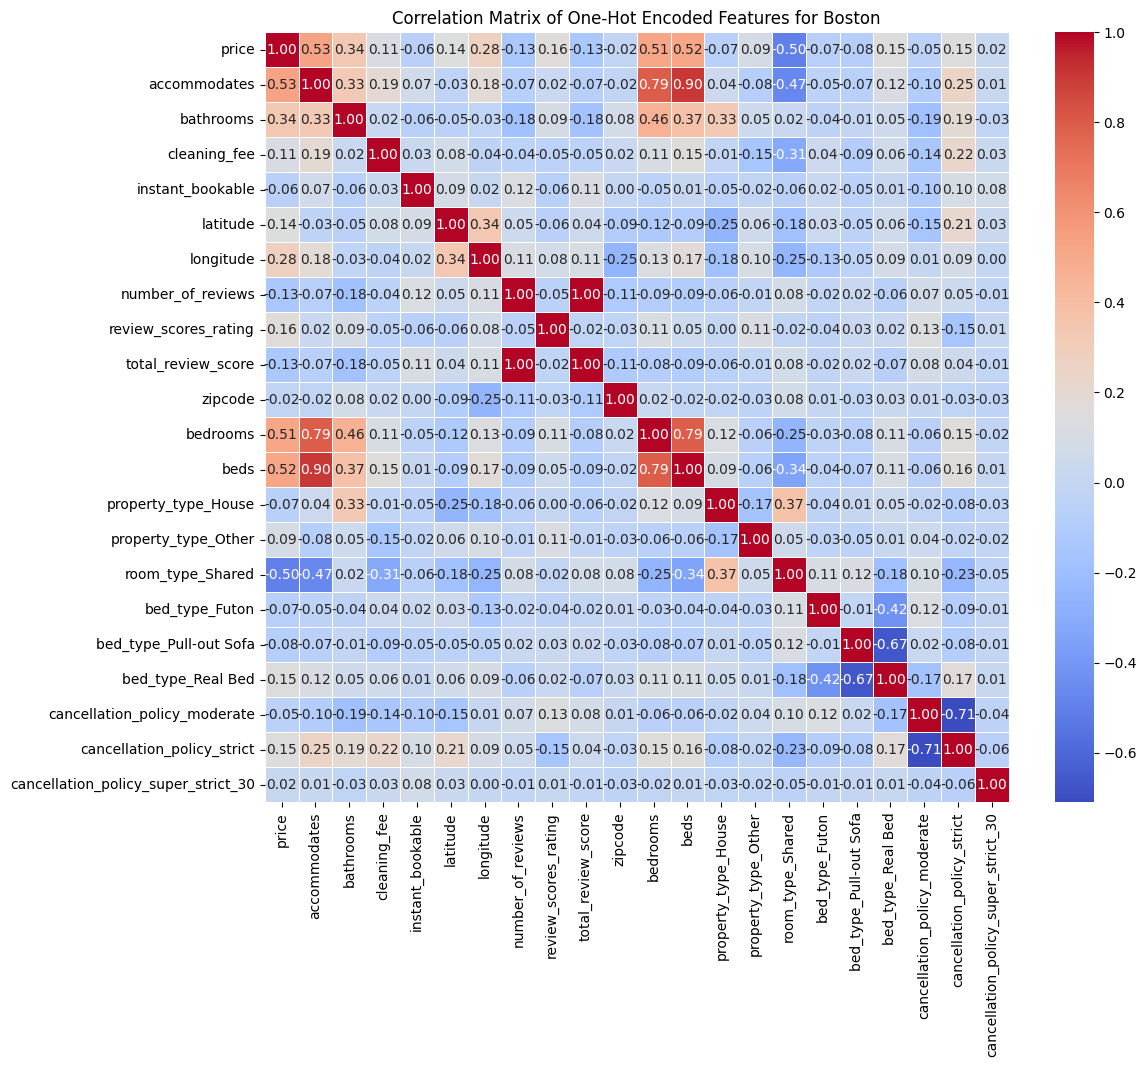

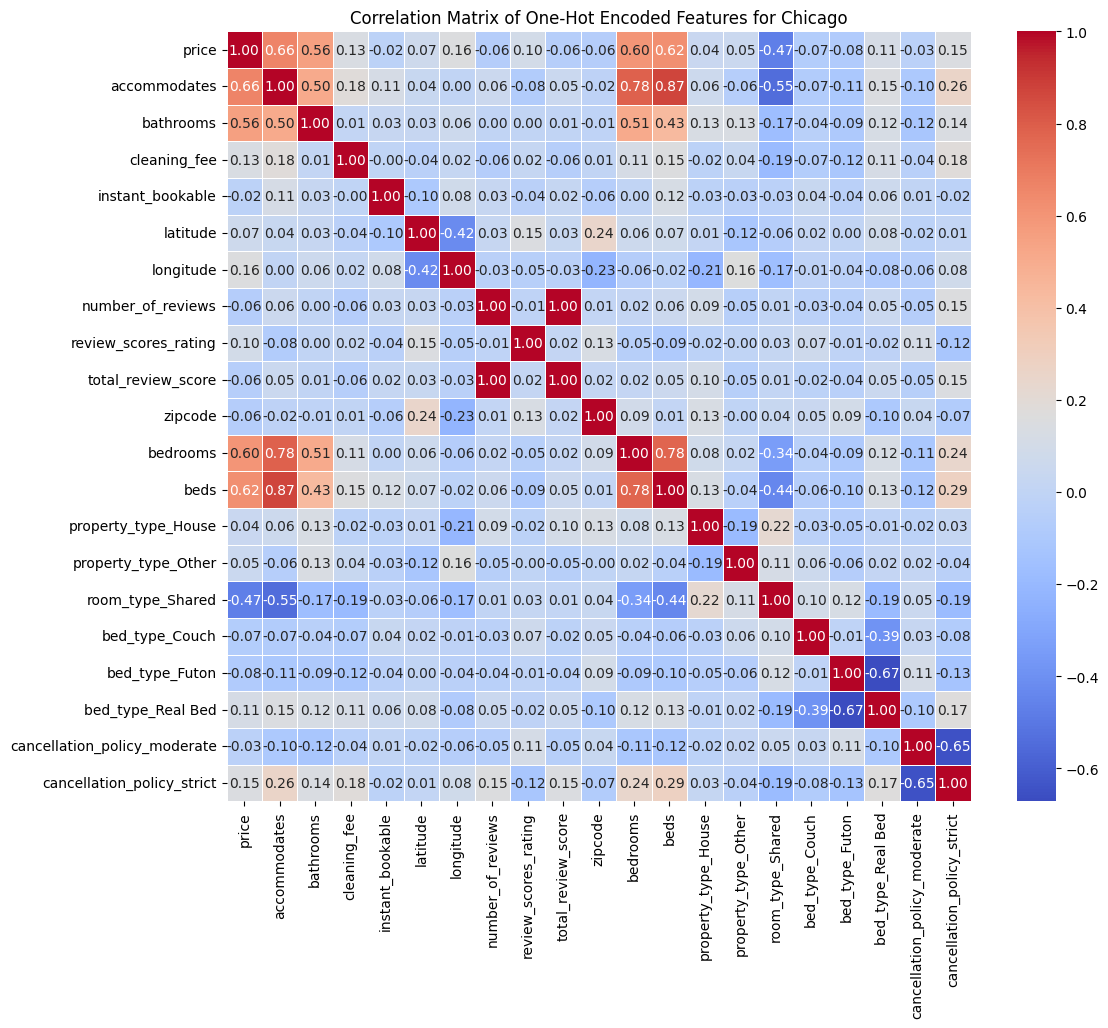

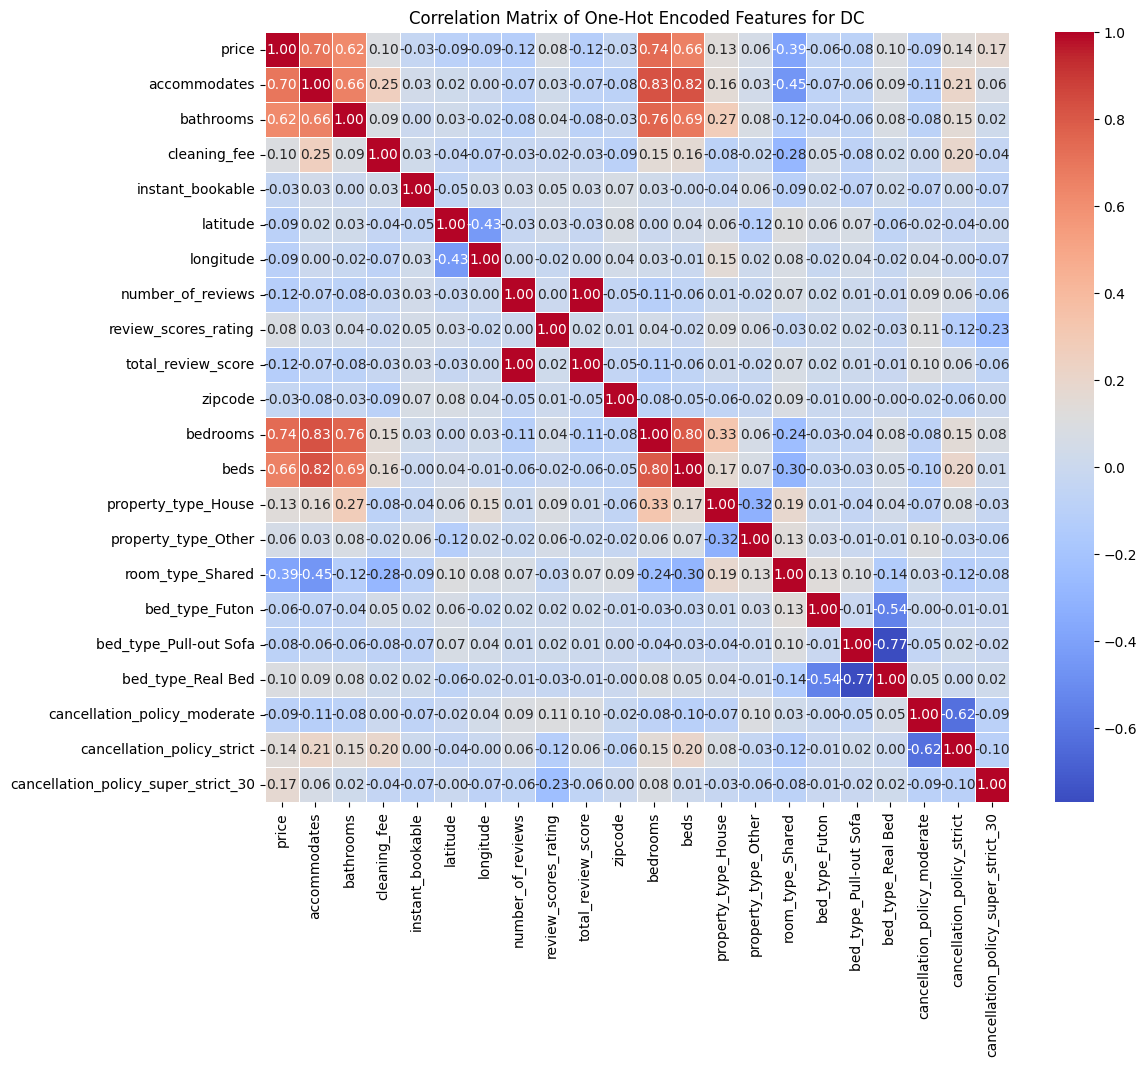

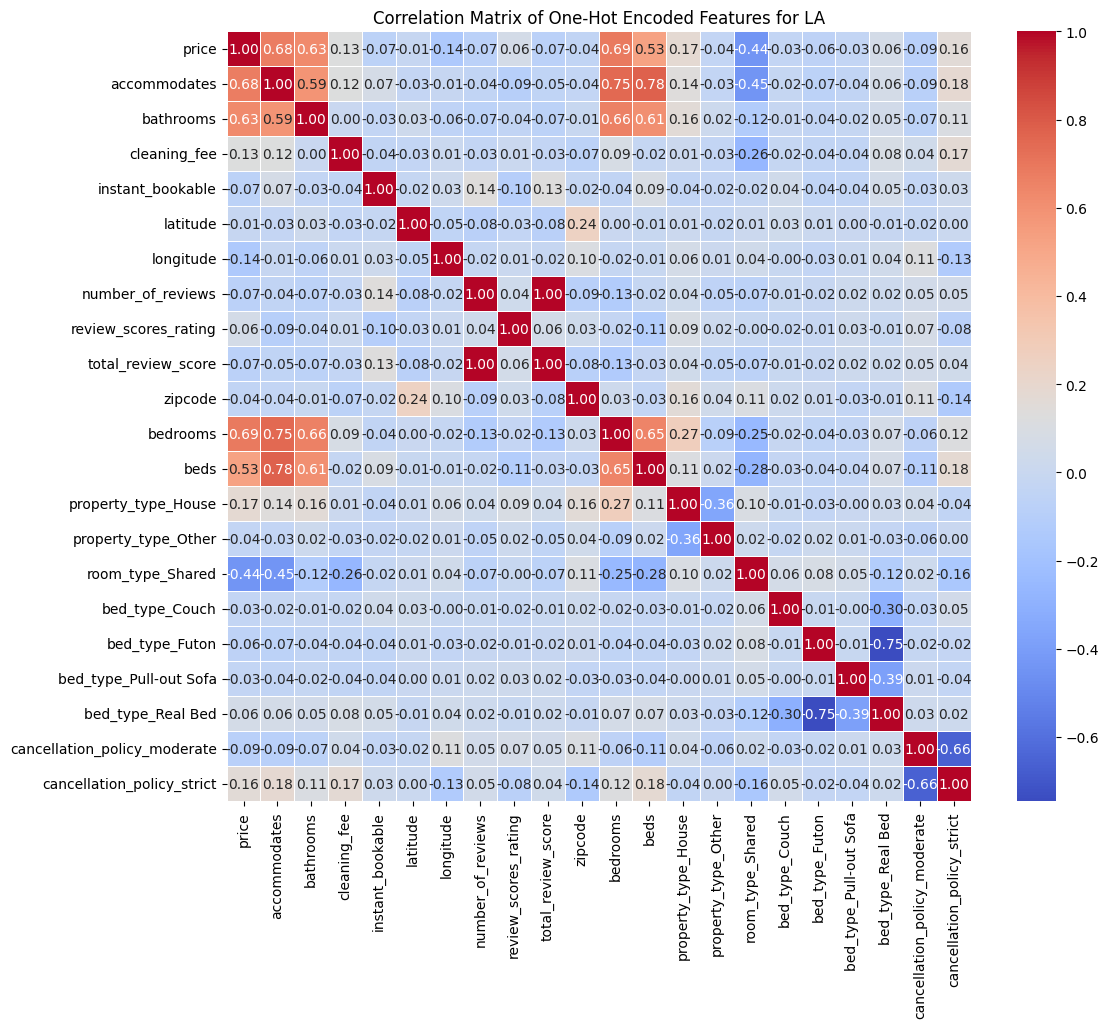

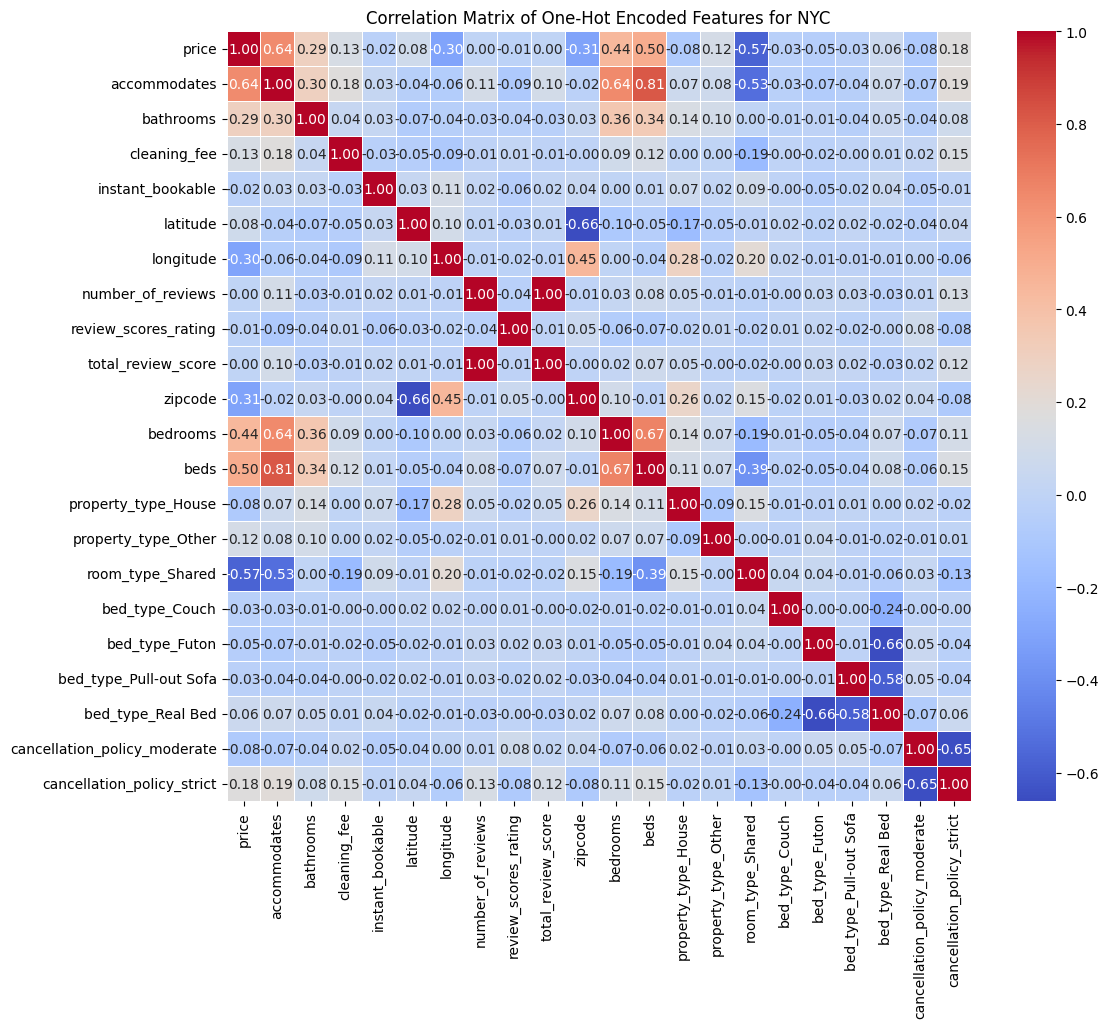

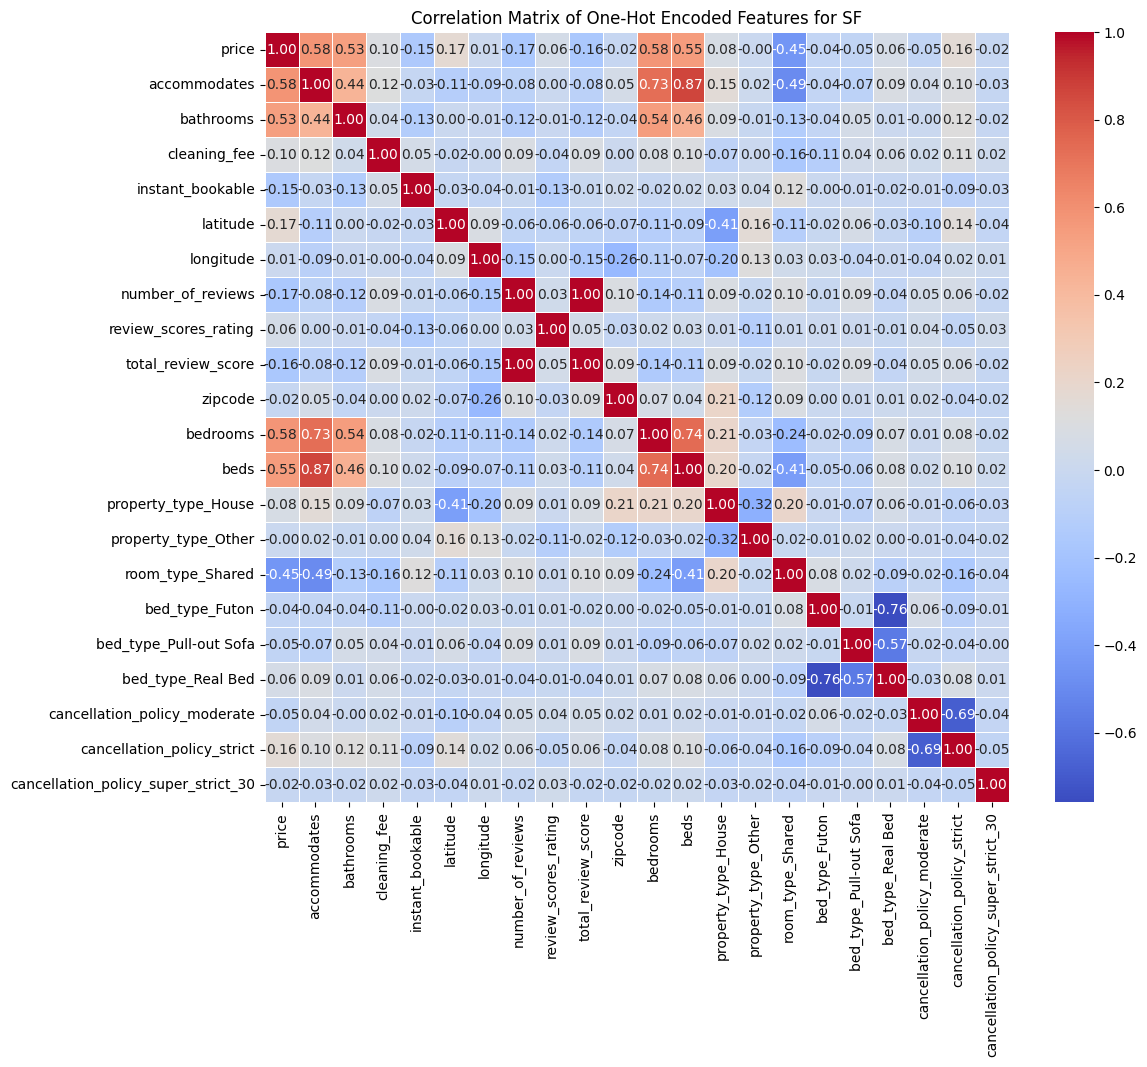

In [8]:
categorical_columns = ['property_type', 'room_type', 'bed_type', 'cancellation_policy'] # Define the categorical columns for encoding
city_dfs = {city: data.drop(columns=['city']) for city, data in clean_df.groupby('city')} # Create a dictionary based on cities
for city, df_city in city_dfs.items(): # Iterate over each city DataFrame in the city_dfs dictionary
    df_encoded = pd.get_dummies(df_city, columns=categorical_columns, drop_first=True) # One-hot encode the specified categorical columns
    correlation_matrix = df_encoded.corr() # Calculate the correlation matrix
    plt.figure(figsize=(12, 10)) # Plot the correlation matrix as a heatmap
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.5, cmap="coolwarm")
    plt.title(f"Correlation Matrix of One-Hot Encoded Features for {city}")
    plt.show()

### Render Correlation of features to price for each city

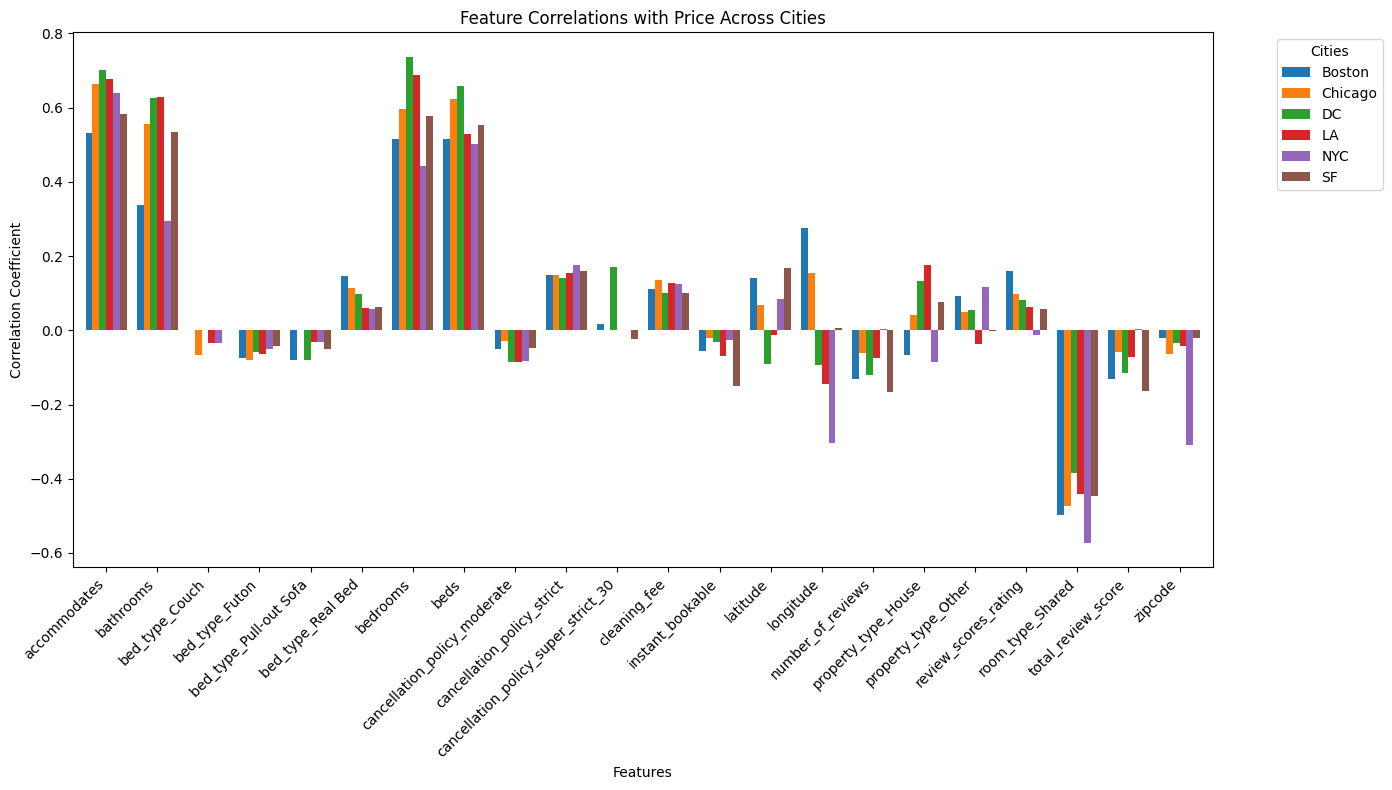

In [9]:
# Dictionary to store correlations for each city
city_price_correlations = {}

# Iterate over each city DataFrame
for city, df_city in city_dfs.items():
    # One-hot encode the specified categorical columns
    df_encoded = pd.get_dummies(df_city, columns=categorical_columns, drop_first=True)

    # Calculate the correlation matrix
    correlation_matrix = df_encoded.corr()

    # Extract correlations with the 'price' column and store in dictionary
    city_price_correlations[city] = correlation_matrix['price']

# Combine all city correlations into a single DataFrame
correlation_df = pd.DataFrame(city_price_correlations)

# Transpose the DataFrame for plotting (features as rows, cities as columns)
correlation_df = correlation_df.T

# Optional: Drop 'price' itself (correlation with itself is always 1)
correlation_df = correlation_df.drop(columns=['price'], errors='ignore')

# Transpose again to make features the index (rows) for plotting
correlation_df = correlation_df.T

# Plot the correlations
correlation_df.plot(kind='bar', figsize=(14, 8), width=0.8)
plt.title("Feature Correlations with Price Across Cities")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Eliminate less useful features

In [10]:
clean_df.drop(columns=['property_type','room_type', 'bed_type', 'cancellation_policy',
                       'cleaning_fee', 'instant_bookable', 'number_of_reviews',
                       'review_scores_rating', 'total_review_score'], inplace=True)
clean_df.columns

Index(['price', 'accommodates', 'bathrooms', 'city', 'latitude', 'longitude',
       'zipcode', 'bedrooms', 'beds'],
      dtype='object')

## EDA Stage 2: Cluster Prices

We have a hunch that airbnb prices might exist in certain bands or classes depending on the quality of the airbnb listings. So we will attempt to "seed" and cluster the prices to find out any observable classes in the price.

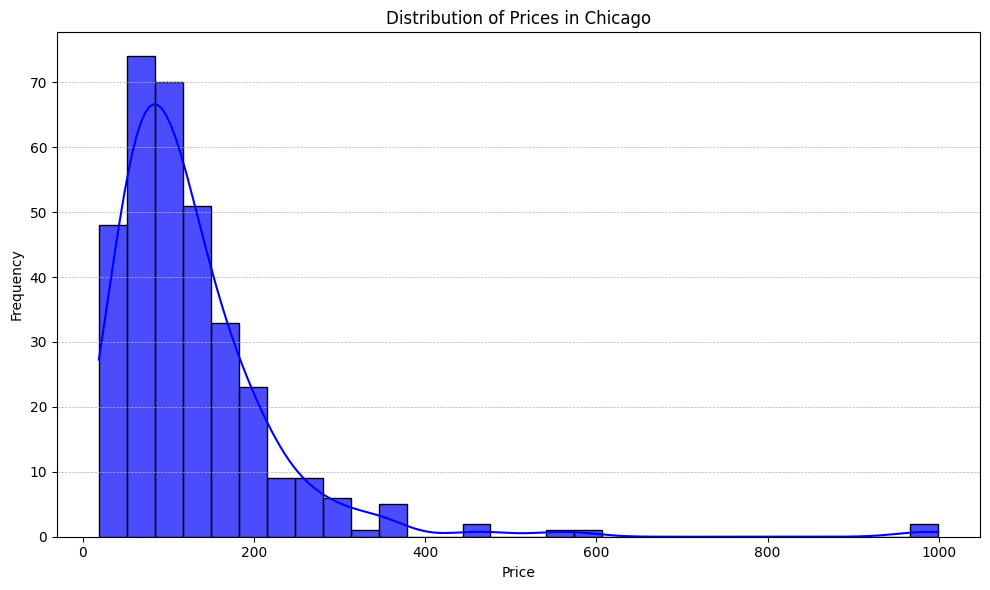

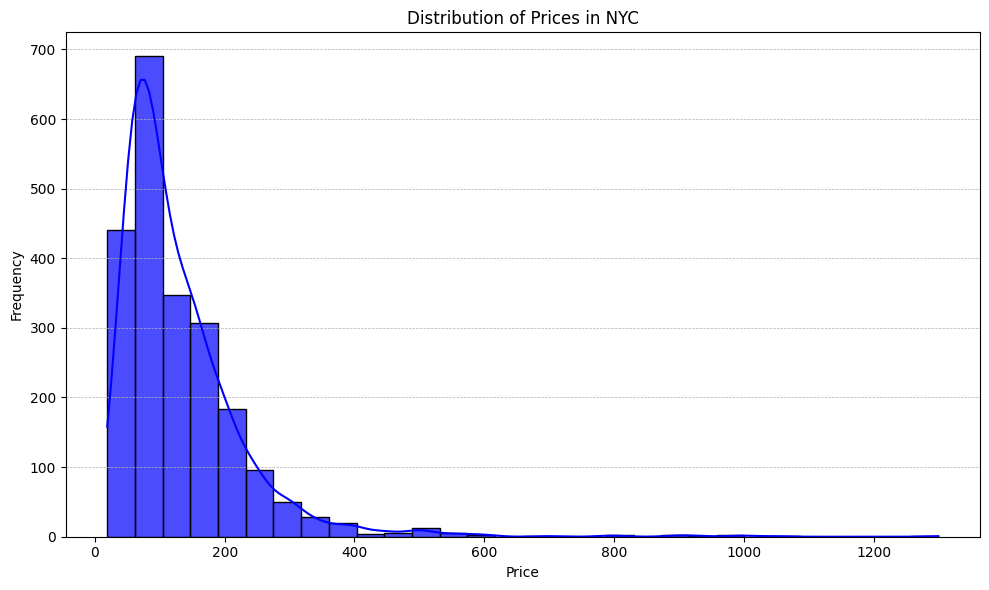

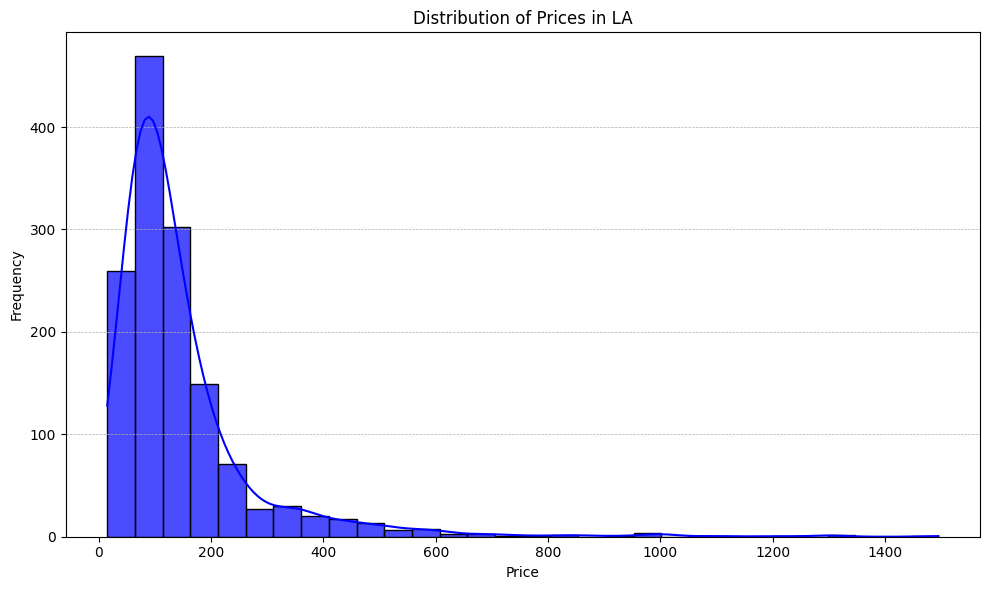

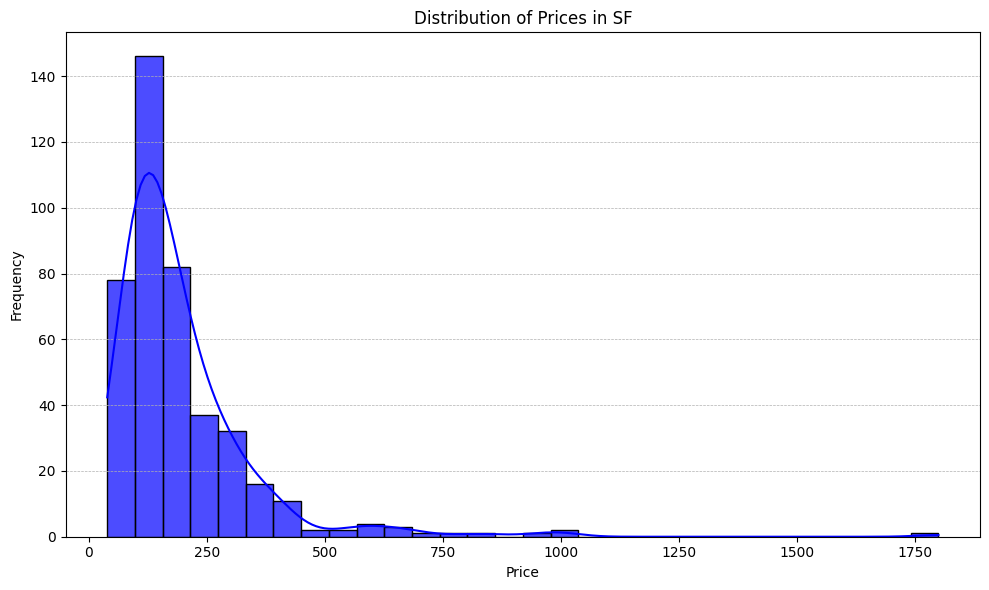

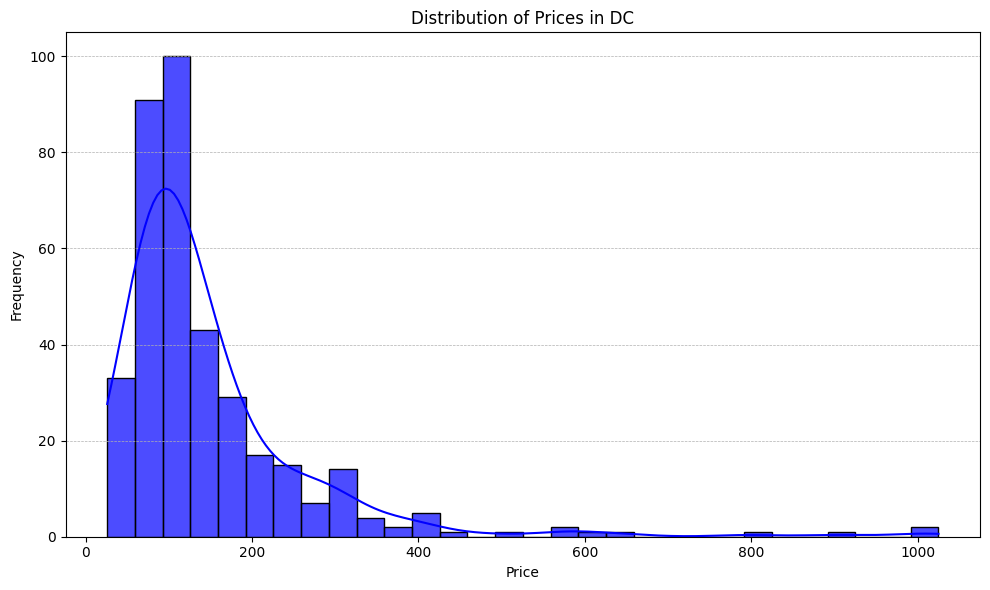

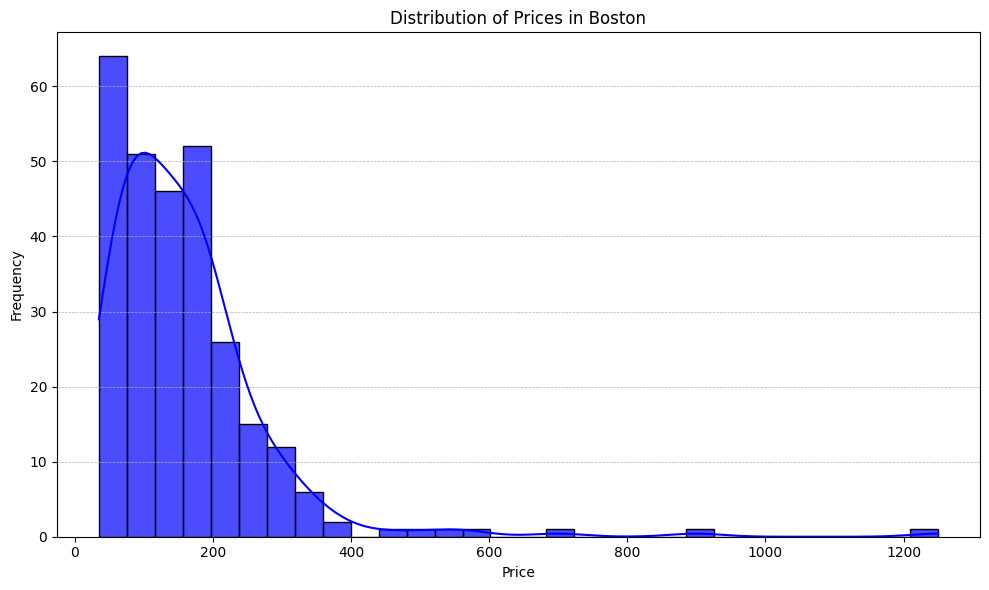

In [19]:
cities = clean_df['city'].unique()

for city in cities:
    plt.figure(figsize=(10, 6))

    # Filter data for the current city
    city_data = clean_df[clean_df['city'] == city]

    # Create a histogram
    sns.histplot(
        city_data['price'],
        bins=30,  # Adjust bins for better granularity
        kde=True,  # Add a kernel density estimate curve
        color='blue',  # Change color if desired
        alpha=0.7
    )

    # Add titles and labels
    plt.title(f"Distribution of Prices in {city}")
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

### Function to cluster prices

In [11]:
def cluster_prices_with_outlier_check(data, initial_clusters=3, max_clusters=10, outlier_threshold=1.5):
    prices = data['price'].values.reshape(-1, 1)
    current_k = initial_clusters
    while current_k <= max_clusters:
        kmeans = KMeans(n_clusters=current_k, random_state=42).fit(prices) # Apply K-means clustering
        data['price_cluster'] = kmeans.labels_
        _, distances = pairwise_distances_argmin_min(prices, kmeans.cluster_centers_)

        # Calculate outlier threshold for each cluster (mean + threshold * std)
        cluster_stats = data.groupby('price_cluster')['price'].agg(['mean', 'std'])
        cluster_stats['threshold'] = cluster_stats['mean'] + outlier_threshold * cluster_stats['std']

        # Check for outliers
        data['is_outlier'] = data.apply(lambda row: row['price'] > cluster_stats.loc[row['price_cluster'], 'threshold'], axis=1)
        outlier_counts = data.groupby('price_cluster')['is_outlier'].sum()
        print(f"K = {current_k}, Outliers per Cluster: {outlier_counts.tolist()}")
        if all(outlier_counts < 0): # If minimal outliers, exit loop
          break
        current_k += 1 # Otherwise, increase number of clusters and retry
    return data, kmeans, cluster_stats

K = 3, Outliers per Cluster: [151, 8, 417]
K = 4, Outliers per Cluster: [165, 2, 294, 30]
K = 5, Outliers per Cluster: [141, 2, 253, 13, 57]
K = 6, Outliers per Cluster: [133, 2, 20, 8, 46, 119]
K = 7, Outliers per Cluster: [137, 1, 20, 12, 39, 119, 1]
K = 8, Outliers per Cluster: [54, 1, 105, 22, 7, 1, 12, 154]
K = 9, Outliers per Cluster: [54, 0, 105, 22, 5, 1, 12, 154, 1]
K = 10, Outliers per Cluster: [56, 0, 86, 22, 5, 1, 12, 65, 1, 0]


<ipython-input-12-e87416fb2ea1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sorted_price_cluster', y='price', data=df_clustered, palette="coolwarm")


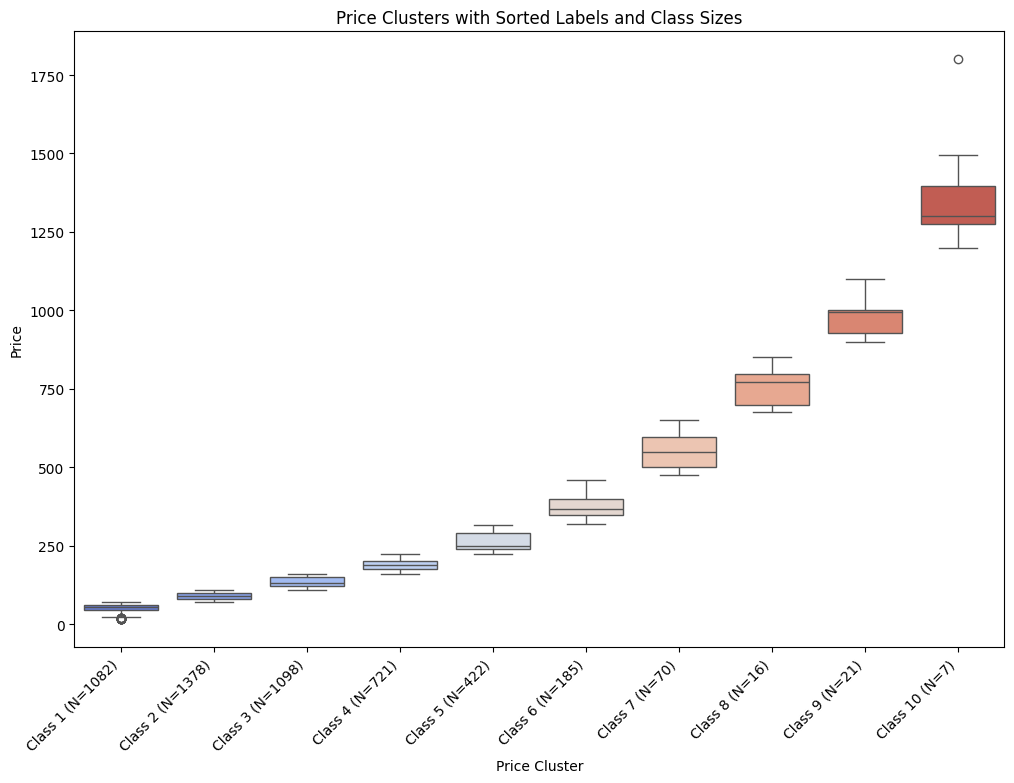

In [12]:
df_filtered = clean_df[['price']].copy()  # Use a filtered DataFrame with the 'price' column
df_clustered, kmeans_model, cluster_ranges = cluster_prices_with_outlier_check(df_filtered) # Run clustering and outlier check

# Sort clusters by price ranges
sorted_clusters = cluster_ranges.sort_values('mean').reset_index()
sorted_clusters['ordered_cluster'] = sorted_clusters.index + 1
cluster_mapping = sorted_clusters.set_index('price_cluster')['ordered_cluster'].to_dict()
df_clustered['sorted_price_cluster'] = df_clustered['price_cluster'].map(cluster_mapping) # Map sorted clusters to original DataFrame
class_sizes = df_clustered['sorted_price_cluster'].value_counts().sort_index() # Calculate class sizes
x_labels = [f"Class {label} (N={class_sizes[label]})" for label in sorted(class_sizes.index)] # Prepare labels with class sizes

# Visualize clusters with updated x-axis labels
plt.figure(figsize=(12, 8))
sns.boxplot(x='sorted_price_cluster', y='price', data=df_clustered, palette="coolwarm")
plt.title("Price Clusters with Sorted Labels and Class Sizes")
plt.xlabel("Price Cluster")
plt.ylabel("Price")
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45, ha='right')
plt.show()

In [13]:
clean_df["price_class"] = df_clustered["sorted_price_cluster"]

### PCA Plot of feature space using price_class to identify patterns.


Processing city: Chicago


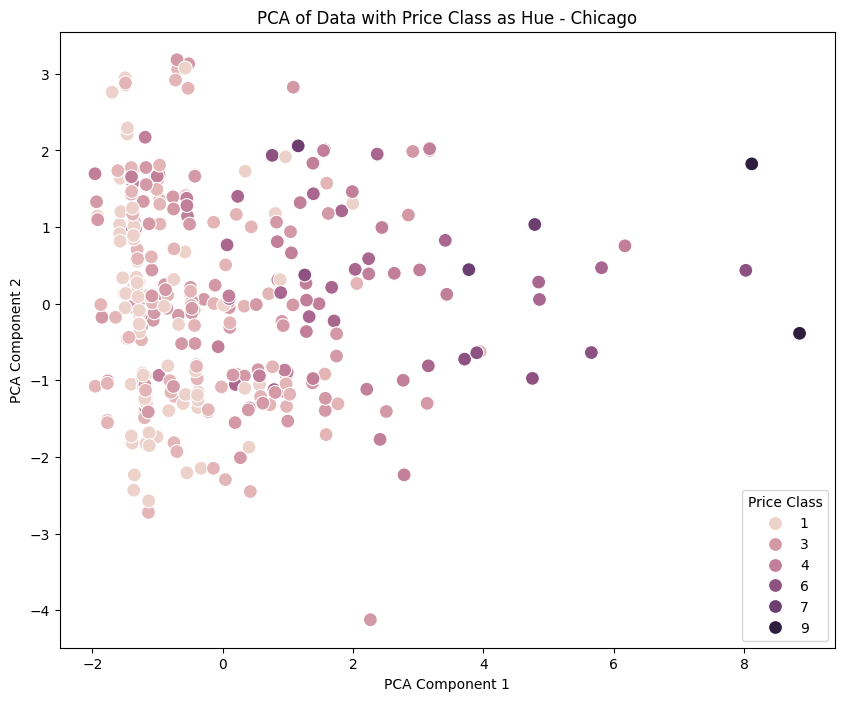


Processing city: NYC


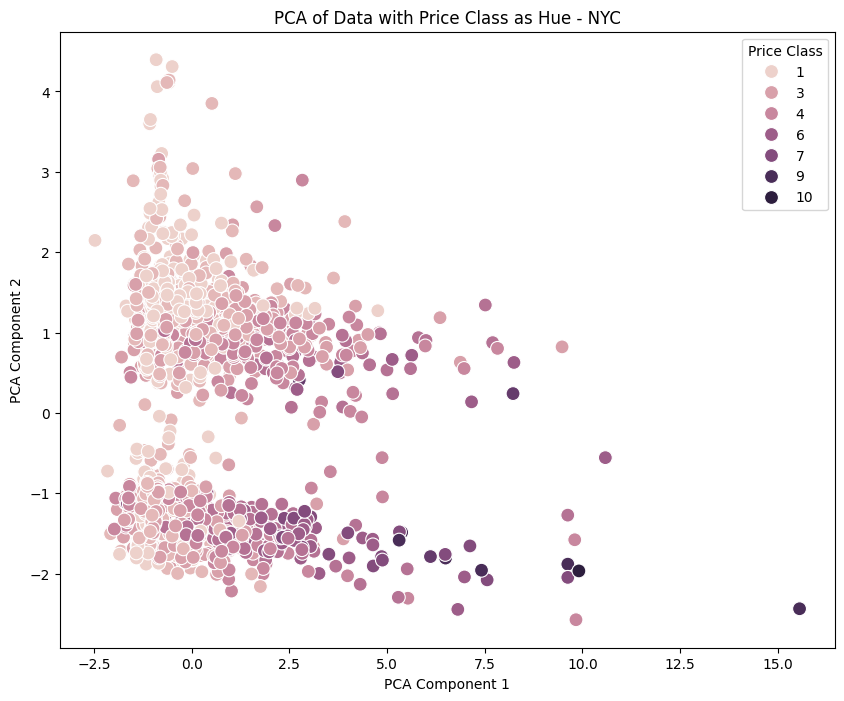


Processing city: LA


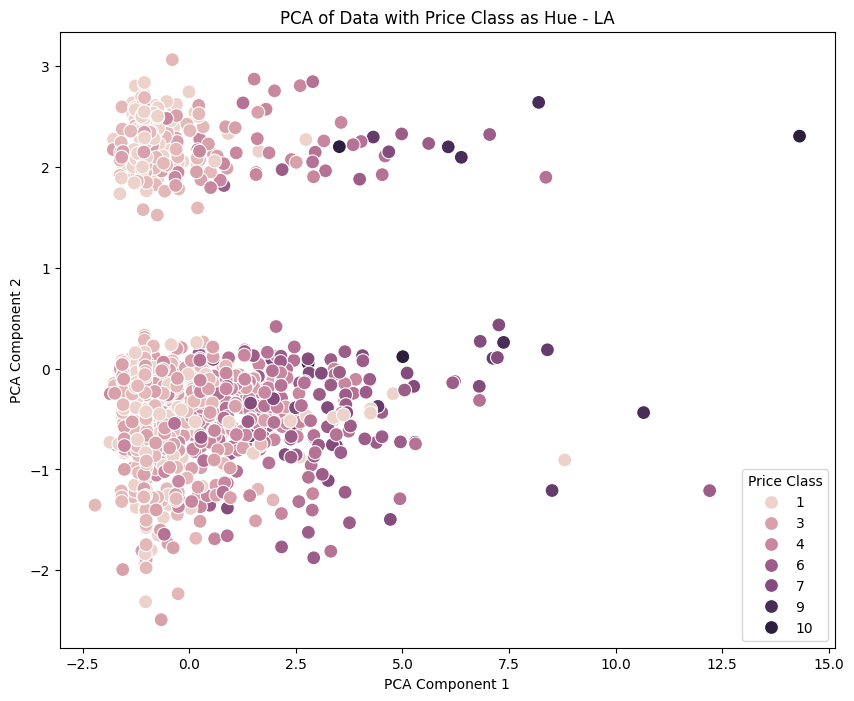


Processing city: SF


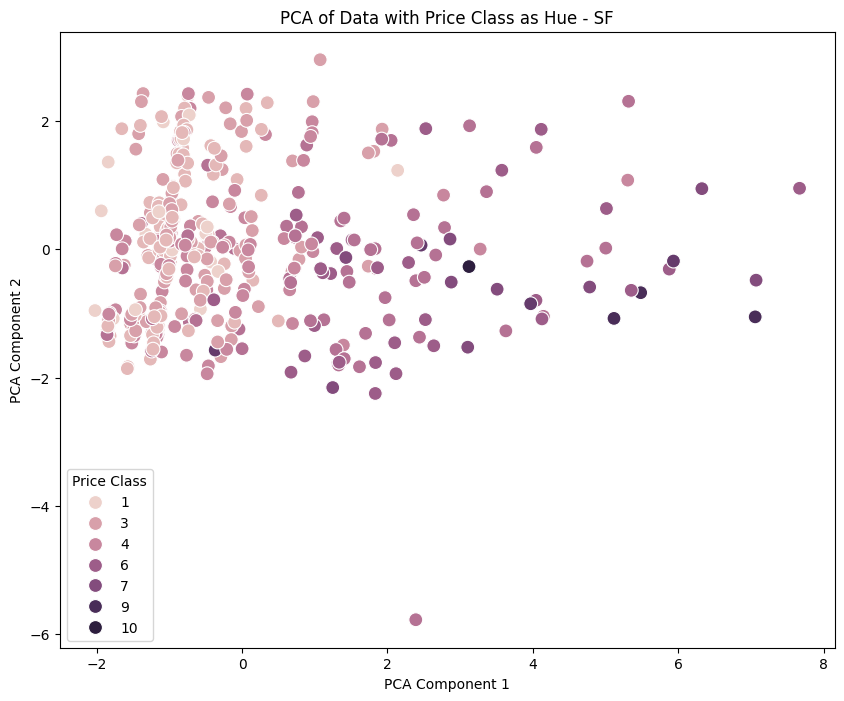


Processing city: DC


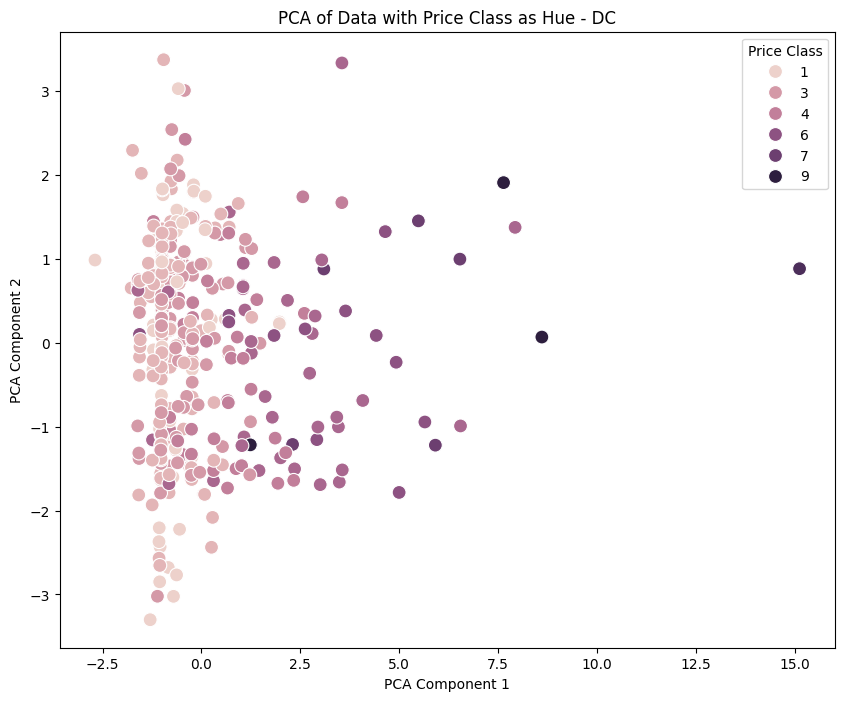


Processing city: Boston


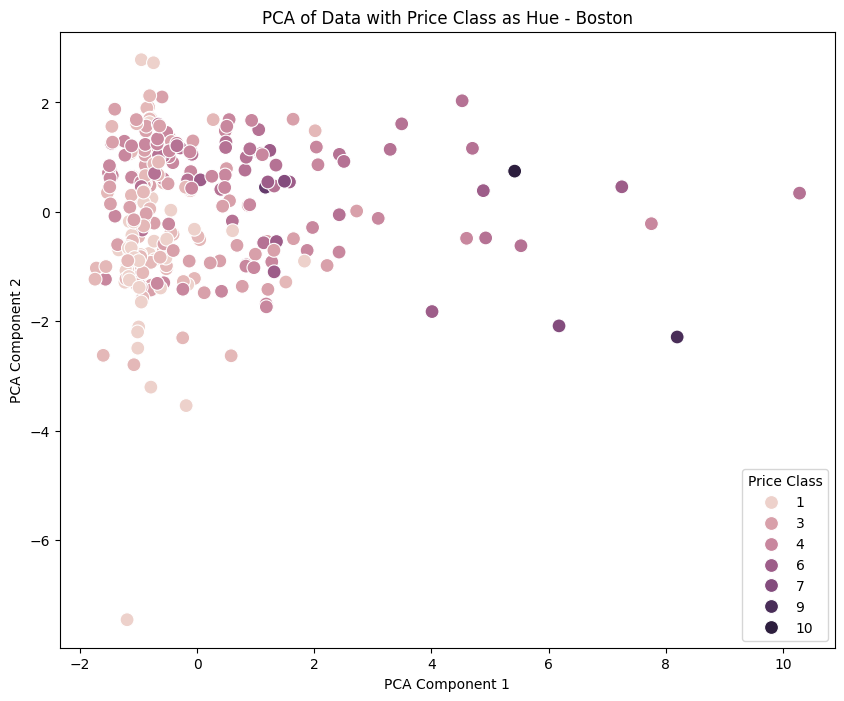

In [14]:
cities = clean_df['city'].unique() # List of unique cities

# Loop through each city to perform PCA and visualize with price_class as hue
for city in cities:
    print(f"\nProcessing city: {city}")
    city_data = clean_df[clean_df['city'] == city].copy() # Filter city
    features = city_data.drop(columns=['price', 'price_class', 'city'], errors='ignore')
    scaler = StandardScaler() # Normalize the data
    features_scaled = scaler.fit_transform(features) # Normalize the data

    # Apply PCA
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    city_data['pca_1'] = features_pca[:, 0]
    city_data['pca_2'] = features_pca[:, 1]

    # Visualize the PCA results with price_class as hue
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=city_data, x='pca_1', y='pca_2', hue='price_class', s=100)
    plt.title(f'PCA of Data with Price Class as Hue - {city}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Price Class')
    plt.show()

### t-SNE Plot of feature space using price_class to identify patterns.


Processing city: Chicago


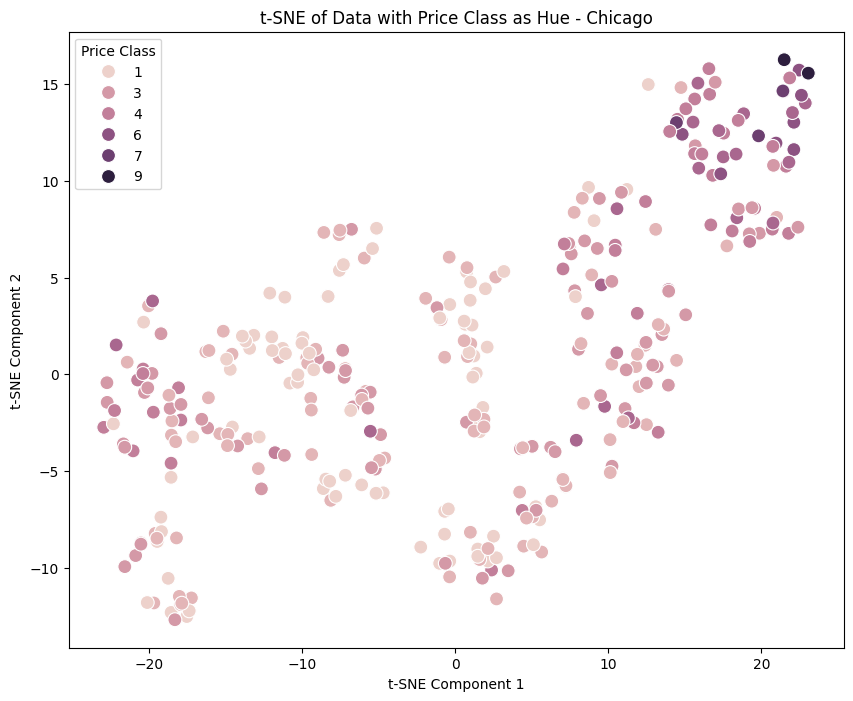


Processing city: NYC


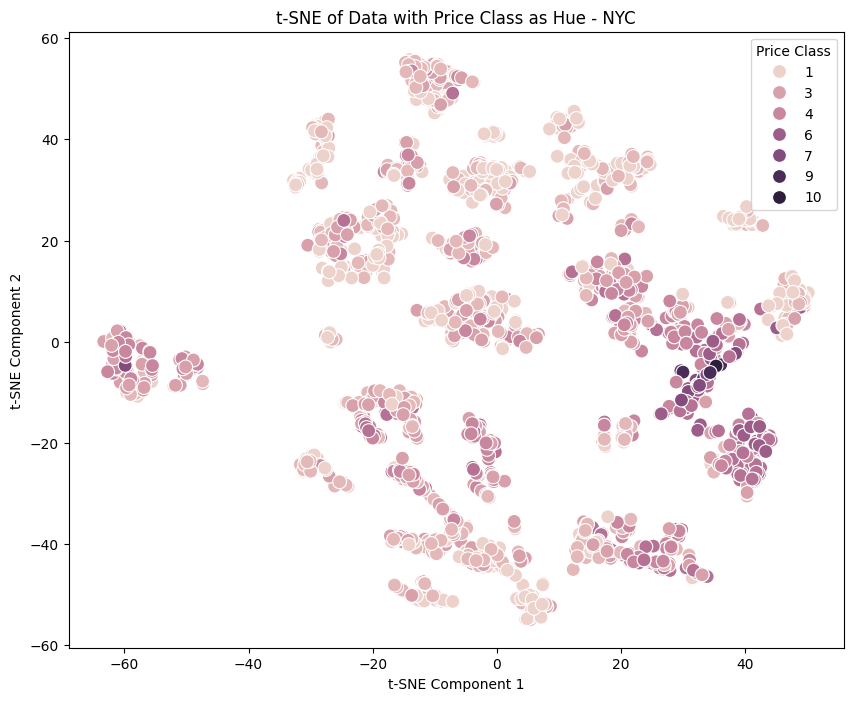


Processing city: LA


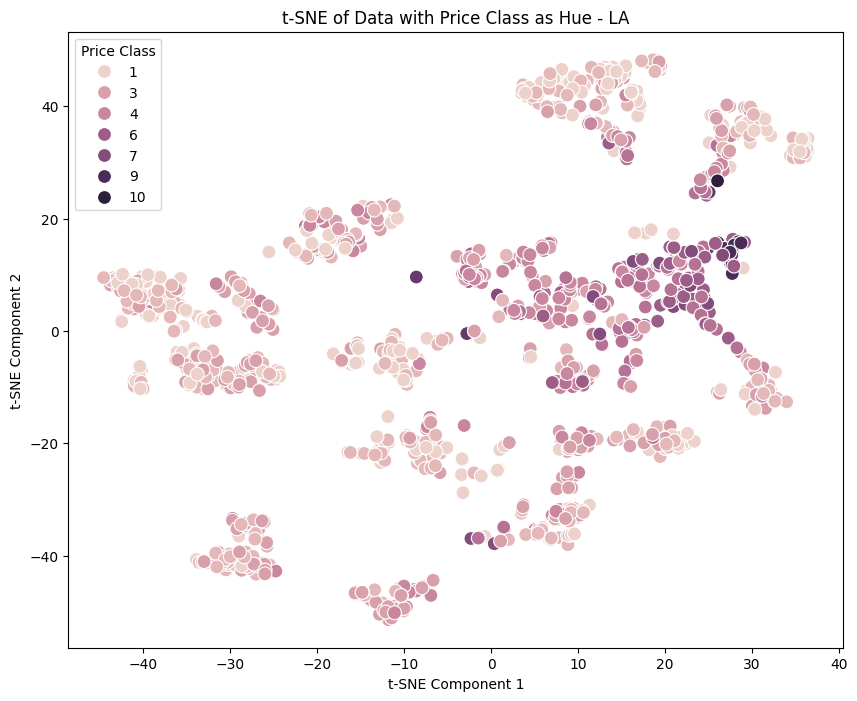


Processing city: SF


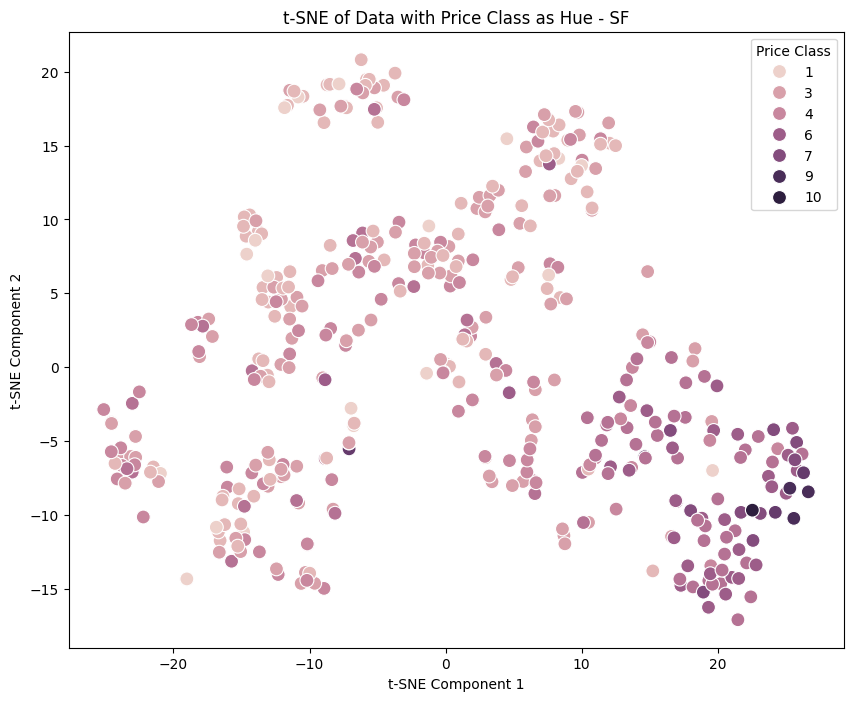


Processing city: DC


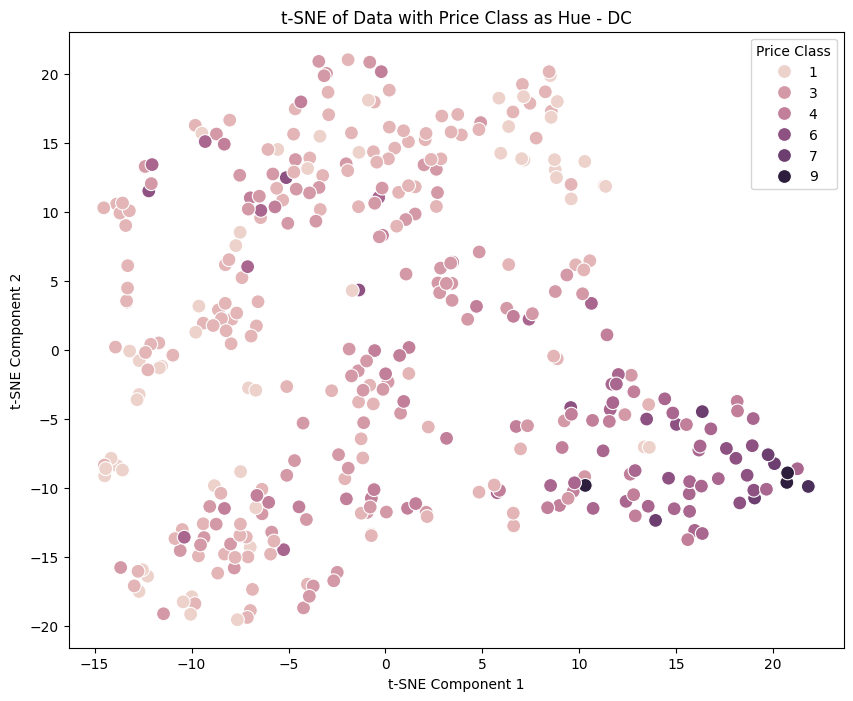


Processing city: Boston


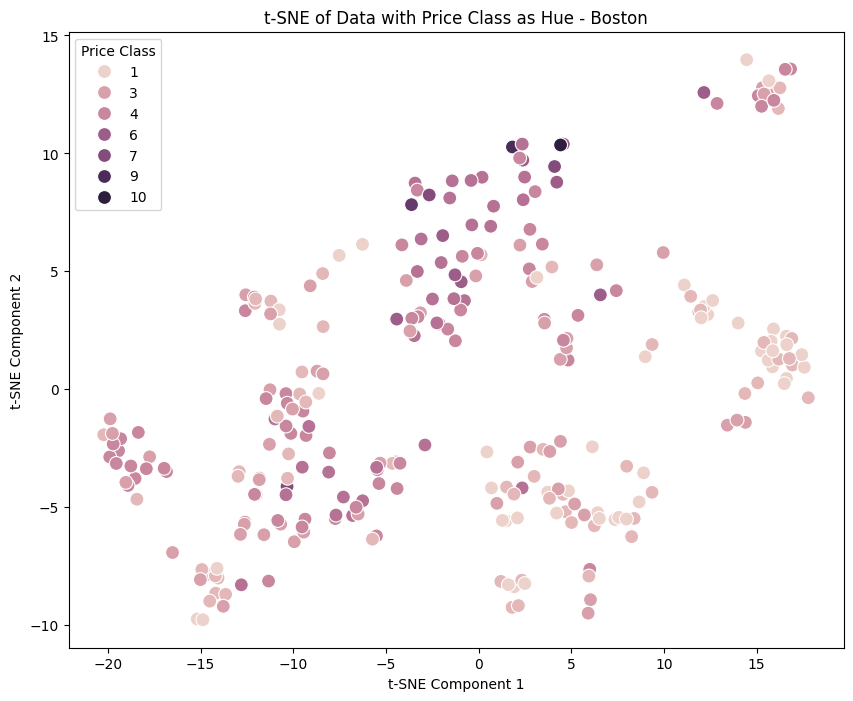

In [15]:
# Loop through each city to perform t-SNE and visualize with price_class as hue
for city in cities:
    print(f"\nProcessing city: {city}")
    city_data = clean_df[clean_df['city'] == city].copy() # Filter data for the current city
    features = city_data.drop(columns=['price', 'price_class', 'city'], errors='ignore')

    scaler = StandardScaler() # Normalize the data
    features_scaled = scaler.fit_transform(features) # Normalize the data

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_tsne = tsne.fit_transform(features_scaled)
    city_data['tsne_1'] = features_tsne[:, 0]
    city_data['tsne_2'] = features_tsne[:, 1]

    # Visualize the t-SNE results with price_class as hue
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=city_data, x='tsne_1', y='tsne_2', hue='price_class', s=100)
    plt.title(f't-SNE of Data with Price Class as Hue - {city}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Price Class')
    plt.show()

Both plots show that some sort of discernable pattern exists and that it can be quite hard to distinguish them from each other. In particular, we could use K-nearest neighbours using t-SNE data since we can gauge an estimate of the price based on other nearby datapoints.

## EDA Stage 3: GeoSpatial Patterns

We also considered the possiblity that geospatial location of these airbnb listings could be a key factor in their price.

In [16]:
def create_interactive_geospatial_plot(data, city_column='city', lat_column='latitude', lon_column='longitude', price_class_column='price_class', city=None):
    """
    Creates an interactive geospatial scatter plot with filtering capabilities for price_class.

    Parameters:
    - data: DataFrame containing Airbnb data.
    - city_column: Column name for city.
    - lat_column: Column name for latitude.
    - lon_column: Column name for longitude.
    - price_class_column: Column name for price class.
    - city: Optional city filter. If None, includes all data.
    """
    city_data = data[data[city_column] == city] if city else data
    fig = px.scatter(
        city_data,
        x=lon_column,
        y=lat_column,
        color=price_class_column,
        title=f"Geospatial Distribution of Listings by Price Class - {city}" if city else "Geospatial Distribution of Listings by Price Class",
        labels={lon_column: "Longitude", lat_column: "Latitude", price_class_column: "Price Class"},
        hover_data=['price', city_column],
        color_discrete_sequence=px.colors.qualitative.Set1,
        width=900,
        height=700
    )
    fig.update_layout(
        legend_title_text='Price Class',
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    )
    fig.update_traces(marker=dict(size=10, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))
    return fig

In [17]:
clean_df["city"].unique()

array(['Chicago', 'NYC', 'LA', 'SF', 'DC', 'Boston'], dtype=object)

In [18]:
city_name = "NYC"  # Replace with the city you want to visualize
fig = create_interactive_geospatial_plot(clean_df, city=city_name)

# Show the interactive plot
fig.show()

GeoSpatial mapping shows that there are cases where expensive airbnb listings are isolated from other listings. There also seems to be disctinct regions where prices of certain ranges can be found more commonly. This suggests that we are lacking information about the geospatial region around these listings and that we need to engineer new features that can better represent the geospatial value of these airbnb listings to justify their price.